#논문개요
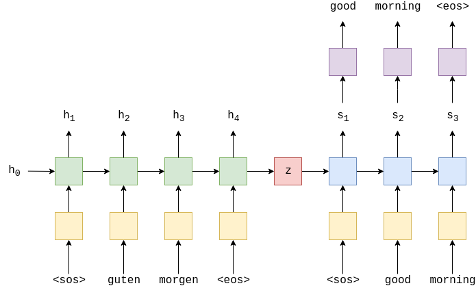

   본 논문은 다음 <그림 1>과 같은 기존 Encoder-Decoder 모델을 사용했을 때, 입력문장의 길이가 길어질수록 성능이 급격하게 떨어지는 문제를 해결하기 위해 제안한 Attention 기법에 관한 논문이다. 기존 방식에서는 source sentence를 고정된 크기의 vector에 압축하기 때문에, 학습셋보다 긴 문장에 대해 처리하지 못한다는 문제점이 존재했다.


 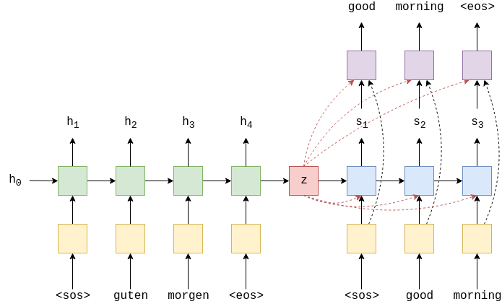


   따라서, 이를 해결하기 위해 본 논문에서는 align과t translate를 함께 하는 방법을 제안하고 있다. 각 Decoder 에서 문장을 번역할 때마다 전체 입력 문장을 고려하는 것이다. Decoder에서 해당 step의 번역할 부분과 가장 관련이 높은 입력문장 부분을 집중적으로 참고한다고 하여 Attention 모델이라고 한다.




# 코드분석

**라이브러리 import**

In [ ]:
!python --version

Python 3.9.16


In [ ]:
  !wget https://www.python.org/ftp/python/3.7.0/Python-3.7.0.tgz
  !tar xvfz Python-3.7.0.tgz
  !Python-3.7.0/configure
  !make
  !sudo make install


  # torchtext 사용을 위해 python downgrade 진행

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_calltips.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_codecontext.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_colorizer.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_config.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_config_key.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_configdialog.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_debugger.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_delegator.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_editmenu.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_editor.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_grep.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_help.py'...
Compiling '/usr/local/lib/python3.7/idlelib/idle_test/test_help_a

In [ ]:
!python --version

# 다운그레이드 잘 됐는지 확인

Python 3.7.0


In [ ]:
!pip install torch==1.9.0 torchtext==0.10.0

# torchtext.legacy 를 사용하기 위해 torch downgrade 진행

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.5 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.1
    Uninstalling torchtext-0.15.1:
      Successfully uninstalled torchtext-0.15.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.15.1+cu118 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
torchdata 0.6.0 requires torch==2.0.0, but you have torch 1.9.0 which is incompatible.
torchaudio 2.0.1+cu118 requires torch==2.0.0, but 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator


import spacy
import numpy as np

import random
import math
import time

**랜덤 시드 생성**

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

**독일, 영어 번역할 것 불러오기**

In [ ]:
import spacy
spacy.__version__

'3.5.1'

In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_sm")
spacy.cli.download("de_core_news_sm")

# 버전이 올라가면서 그냥 spacy 안에는 데이터가 없음 -> spacy.cli에서 download

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

**토큰화 하기**

 문장을 단어 단위로 토큰화

In [ ]:
def tokenize_de(text):
    """
    독일문장을 단어 단위로 토큰화하여 list에 저장
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    영어문장을 단어 단위로 토큰화하여 list에 저장
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

**Field 정의**

*아직 전처리는 하지 않았음을 명심*


---



init_token = 'sos' # start of sentence

eos_token = 'eos' # end of sentence / 문장이 끝났다는 것까지 학습시킴

lower = 'true' # 전부 소문자로 지정

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True)

**데이터 로드**

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:00<00:00, 5.69MB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 1.83MB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 1.62MB/s]


**단어 생성**



---

단어 사전 생성 , min_freq는 단어의 최소 등장 빈도 조건


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
TRG.vocab.itos[:15]

# 잘 생성됐는지 itos 함수 사용해서 확인

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 'a',
 '.',
 'in',
 'the',
 'on',
 'man',
 'is',
 'and',
 'of',
 'with',
 'woman']

In [ ]:
print(len(TRG.vocab))
TRG.vocab.stoi

5893


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f0c1e14bfa0>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'a': 4,
             '.': 5,
             'in': 6,
             'the': 7,
             'on': 8,
             'man': 9,
             'is': 10,
             'and': 11,
             'of': 12,
             'with': 13,
             'woman': 14,
             ',': 15,
             'two': 16,
             'are': 17,
             'to': 18,
             'people': 19,
             'at': 20,
             'an': 21,
             'wearing': 22,
             'shirt': 23,
             'young': 24,
             'white': 25,
             'black': 26,
             'his': 27,
             'while': 28,
             'blue': 29,
             'men': 30,
             'red': 31,
             'sitting': 32,
             'girl': 33,
             'boy': 34,
             'dog': 35,
             

In [ ]:
SRC.vocab.itos[:15]

# 잘 생성됐는지 itos 함수 사용해서 확인

['<unk>',
 '<pad>',
 '<sos>',
 '<eos>',
 '.',
 'ein',
 'einem',
 'in',
 'eine',
 ',',
 'und',
 'mit',
 'auf',
 'mann',
 'einer']

In [ ]:
print(len(SRC.vocab))
SRC.vocab.stoi

7853


defaultdict(<bound method Vocab._default_unk_index of <torchtext.legacy.vocab.Vocab object at 0x7f0dc7905850>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             '.': 4,
             'ein': 5,
             'einem': 6,
             'in': 7,
             'eine': 8,
             ',': 9,
             'und': 10,
             'mit': 11,
             'auf': 12,
             'mann': 13,
             'einer': 14,
             'der': 15,
             'frau': 16,
             'die': 17,
             'zwei': 18,
             'einen': 19,
             'im': 20,
             'an': 21,
             'von': 22,
             'sich': 23,
             'dem': 24,
             'mädchen': 25,
             'junge': 26,
             'vor': 27,
             'zu': 28,
             'steht': 29,
             'männer': 30,
             'sitzt': 31,
             'hund': 32,
             'den': 33,
             'straße': 34,
             'während': 35,
  

**상황에 따라 gpu 혹은 cpu를 사용하도록 장치 지정**

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**iterator 생성**

Iterator를 생성한다. Iterator로는 torchtext의 BucketIterator를 사용하였다.

Iterator는 데이터셋에서 batch_size만큼의 데이터를 샘플링하여 batch를 생성하는 객체로, pytorch에서의 DataLoader와 유사한 기능을 한다.

Iterator 중에서도 BucketIterator는 batch를 생성할 때 비슷한 길이의 데이터(즉, 비슷한 수의 단어로 구성된 문장)를 함께 묶는 iterator이다.

비슷한 길이의 데이터를 묶어 batch로 사용하는 이유는, 하나의 batch에 해당하는 텐서를 구성할 때 길이가 짧은 문장에는 padding token을 더해 길이가 가장 긴 문장과 같은 길이로 만들어 batch를 생성하기 때문이다.

BucketIterator를 사용하면 길이가 비슷한 데이터끼리 batch를 만들기 때문에, 추가되는 padding token의 수를 최소화 할 수 있다.

데이터셋과 배치 사이즈, device를 인자로 입력해 iterator를 생성하였다.
Iterator를 생성할 때 아래와 같이 .splits() 메소드를 사용하면 학습, 검증, 테스트용 iterator를 따로 생성할 필요 없이 한번에 생성할 수 있다.


In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE,
    device = device)

# **Encoder**

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        '''
           self.embedding에 토큰의 정수 인덱스(vocabulary에서 지정된)가 들어오면 emb_dim차원의 벡터로 임베딩하여 출력
           input_dim은 source 언어 토큰의 가짓수(source vocabulary의 길이)에 해당
           self.embedding은 input_dim 갯수의 emb_dim 차원의 임베딩 벡터 출력가능
        '''

        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        '''
           RNN은 bidirectional GRU를 사용
           파라미터 : input 차원, hidden size, bidirectional True로 설정
        '''

        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        '''
           인코더는 양방향 RNN이어서 enc_hid_dim*2 차원의 hidden state를 갖지만 디코더는 단방향 RNN이어서 dec_hid_dim 차원의 hidden state를 갖는다.
           따라서 input size가 enc_hid_dim*2, output size가 dec_hid_dim인 nn.Linear 레이어를 사용하여 
           인코더 hidden states의 차원을 디코더 hidden states의 차원에 맞게 조절한다.
           차원을 조절하는 이유는 디코더 RNN hidden state의 초기값이 인코더 RNN의 마지막 hidden state로부터 초기화되기 때문이다.
        '''

        self.dropout = nn.Dropout(dropout)
        '''
           드롭아웃 레이어 (과적합 억제)
        '''
        
    def forward(self, src):
        
        '''src 텐서값 출력
        print("src")
        print("shape : ", src.shape)
        print(src)'''
        embedded = self.embedding(src)
        '''임베딩된 텐서의 값을 출력
        print("embedded before dropout")
        print("shape : ", embedded.shape)
        print(embedded)'''
        embedded = self.dropout(embedded)
        '''드롭아웃 이후 임베딩 텐서의 값을 출력
        print("embedded after dropout")
        print("shape : ", embedded.shape)
        print(embedded)'''
        outputs, hidden = self.rnn(embedded)
        '''outputs 텐서와 hidden 텐서의 크기와 값 출력
        print("outputs")
        print("shape : ", outputs.shape)
        print(outputs)
        print("hidden")
        print("shape : ", hidden.shape)
        print(hidden)'''

        #outputs = [src len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        '''인코더의 마지막 hidden state를 사용해 디코더의 초기 hidden state를 정하기 위해서 
           fully connected layer를 사용해 dec_hid_dim 차원으로 맵핑한다.'''
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        '''Fully connected 레이어를 통과한 후의 hidden 텐서의 크기와 값을 확인하려면 주석처리 해제
        print("hidden after FC layer")
        print("shape : ", hidden.shape)
        print(hidden)'''
        
        #outputs = [src len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

**src**

shape : torch.Size([12, 1])

tensor([[ 2], [43], [54], [53], [21], [ 6], [ 0], [47], [ 6], [ 0], [ 4], [ 3]], device='cuda:0')



---


**embedded before dropout** 

shape : torch.Size([12, 1, 256])

tensor([[[-1.0058e-03, 5.2595e-04, 8.2303e-03, ..., 9.1974e-03, 3.9426e-03, -1.4976e-02]],



---



**embedded after dropout**

shape : torch.Size([12, 1, 256])

tensor([[[-2.0115e-03, 1.0519e-03, 1.6461e-02, ..., 0.0000e+00, 0.0000e+00, -2.9952e-02]],



---


**outputs**
shape : torch.Size([10, 1, 1024])

tensor([[[-0.2559, -0.0889, 0.0823, ..., -0.0383, 0.3844, 0.1425]],



---


**hidden**

shape : torch.Size([2, 1, 512])

tensor([[[ 0.1556, -0.3380, -0.1188, ..., 0.1123, -0.0881, -0.1072]],


---



**hidden after FC layer**

shape : torch.Size([1, 512])

tensor([[ 1.1117e-01, 3.2016e-01, 5.0236e-02, -1.7864e-01, 1.9376e-01, -3.7601e-02, -8.6925e-02, -2.5820e-01, 1.8682e-01, -2.8013e-01, ..., 7.3503e-02, 1.6862e-01, -1.4567e-01, 5.4925e-02, -1.1120e-01, -7.0257e-02, 1.4193e-01, -1.9306e-01, 6.6286e-04, 9.6617e-02, -6.1719e-03, -1.0431e-01, -1.0917e-01, -7.2579e-02, 2.6661e-01, 4.4102e-02, 1.4355e-01]], device='cuda:0', grad_fn=)

# **Attention Layer**

## Attention matrix의 학습

Attention matrix는 디코더에서 weighted(context vector)를 구할 때, 디코더의 fully connected layer로 확률분포를 계산할 때 관여한다. <br>
따라서 cross entropy loss가 역전파되어 디코더가 업데이트 될 때 attention matrix를 계산하는 attention 클래스의 fully connected layer도 오차 역전파를 통해 loss가 작아지는 방향으로 학습된다.

In [ ]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Linear(dec_hid_dim, 1, bias = False)

        '''self.attn과 self.v는는 논문에서 alignment model a(s_i-1, h_j)에 해당하는 fully connected layer 의미
           annotation h_j와 디코더의 이전 hidden state s_i-1을 사용하여 annotation의 가중치 alpha를 계산
        '''
        
    def forward(self, hidden, encoder_outputs):
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        '''(논문의 notation을 따름)
           모든 k에 대해 energy e_ik를 계산하고 결과적으로 alpha_ij를 구하기 위해
           디코더의 이전 time step의 hidden state, s_i-1, 에 해당하는 hidden을 
           src_len(입력 시퀀스의 길이, 논문에서의 T_x)만큼 복제한다.'''
        
        '''hidden의 크기 출력
        print("hidden : ", hidden.shape)'''

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        '''encoder_outputs는 인코더의 모든 time step에서의 hidden states을 의미'''
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        '''encoder_outputs의 크기 출력
        print("encoder_outputs : ", encoder_outputs.shape)'''
        

        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        '''hidden(s_i-1)과 encoder_outputs(h_1,...,h_T_x)를 concatenate하여 self.attn, self.v에 차례로 입력해 energy e_ij를 계산함
           fully connected layer인 self.attn과 self.v 사이의 활성화함수는 tanh로 사용
           고정된 i와 모든 j(1,...,T_x)에 대해 alpha를 계산함
        '''

        '''energy의 크기와 값 출력
        print("energy")
        print("shape : ", energy.shape)
        print(energy)'''

        attention = self.v(energy).squeeze(2)
        '''attention의 크기와 값 출력
        print("attention")
        print("shape : ", attention.shape)
        print(attention)'''

        attention = F.softmax(attention, dim=1)
        '''softmax 이후 attention의 크기와 값 출력
        print("attention")
        print("shape : ", attention.shape)
        print(attention)'''
        
        return attention

## Attention 클래스에서 각 텐서의 크기와 값

### hidden
hidden :  torch.Size([1, 512])<br> 
repeat 함수와 permute 함수가 적용되고 나면 hidden의 크기는 아래와 같이 변한다.<br>
torch.Size([1, 20, 512])


---



### encoder_outputs
encoder_outputs :  torch.Size([1, 20, 1024]) <br>



---


### energy
shape :  torch.Size([1, 11, 512])<br>
tensor([[[-7.7650e-02, -7.3061e-06, -7.7176e-02,  ...,  1.9701e-01,
           9.8334e-03,  2.0467e-01],
         [ 1.0646e-01,  5.6690e-02, -1.3624e-01,  ...,  1.6274e-01,
          -7.8837e-02,  2.0809e-01],
         [ 4.2273e-02,  2.4400e-01, -2.0695e-01,  ..., -1.0549e-01,
           7.1047e-02, -8.8972e-02],
         ...,
         [-9.5785e-03, -4.7416e-02,  9.9112e-02,  ...,  2.0672e-01,
          -1.3523e-01,  4.6240e-02],
         [-1.8347e-01,  1.4507e-03,  6.9254e-03,  ...,  2.9650e-02,
          -1.1803e-01,  2.0337e-02],
         [-5.8472e-02,  1.4870e-01, -9.7312e-02,  ...,  2.0529e-01,
          -6.8486e-02, -1.6317e-01]]], device='cuda:0',
       grad_fn=<TanhBackward0>)<br>


---



### attention
shape :  torch.Size([1, 11])<br>
tensor([[ 0.0863,  0.0298, -0.0402,  0.0391,  0.0356, -0.0545,  0.0689, -0.1209,
         -0.0307,  0.1268,  0.1863]], device='cuda:0',
       grad_fn=<SqueezeBackward1>)<br>



---


### Softmax 이후 attention
shape :  torch.Size([1, 11])
tensor([[0.0959, 0.0906, 0.0845, 0.0914, 0.0911, 0.0833, 0.0942, 0.0779, 0.0853,
         0.0998, 0.1059]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

# **Decoder**

In [ ]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)

        '''RNN은 GRU를 사용하였다. 인코더와 달리 bidirectional=False임'''
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        self.fc_out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        '''인코더와 마찬가지로 과적합 방지를 위해 드롭아웃 사용'''
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(0)

        '''input의 크기와 값 출력
        print("input")
        print("shape : ", input.shape)
        print(input)'''

        '''임베딩하고 드롭아웃을 적용'''
        embedded = self.dropout(self.embedding(input))
        
        '''embedded의 크기와 값 출력
        print("embedded")
        print("shape : ", embedded.shape)
        print(embedded)'''
        
        '''여기서 hidden은 디코더의 이전 time step에서의 hidden state에 해당한다.
           encoder_outputs는 인코더 클래스의 output(모든 time step에서의 hidden states)에 해당한다.
           hidden과 encoder_outputs, 어텐션 레이어를 사용해 a를 계산하는데 여기서 a는 논문에서의 alpha_ij에 해당한다.'''
        a = self.attention(hidden, encoder_outputs)     
        a = a.unsqueeze(1)
        '''a의 크기와 값 출력
        print("a")
        print("shape : ", a.shape)
        print(a)'''
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        
        '''torch.bmm은 batch의 각 요소에 대해서 행렬곱을 수행하는 함수이다. 
           각 데이터의 a(annotation의 가중치)와 encoder_outputs(annotations)를 곱하는 연산이다.
           결과인 weighted는 논문에서 context vector c_i에 해당한다.'''

        weighted = torch.bmm(a, encoder_outputs)

        '''weighted의 크기와 값 출력
        print("weighted")
        print("shape : ", weighted.shape)
        print(weighted)'''
        
        weighted = weighted.permute(1, 0, 2)
        rnn_input = torch.cat((embedded, weighted), dim = 2)

        '''hidden은 디코더 RNN의 이전 hidden state에 해당하고 rnn_input은 y_i-1과 c_i에 해당한다.
           이전 hidden state와 이전에 예측한 단어, context vector를 사용하여 현재 디코더 RNN hidden state s_i를 계산하는 연산이다.
           한 단어씩 예측하고 있으므로 예측하는 시퀀스의 길이인 sequence length는 1이고, 따라서 output과 hidden은 같은 값이다.'''

        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))

        '''output과 hidden의 크기와 값 출력
        print("output")
        print("shape : ", output.shape)
        print(output)
        print("hidden")
        print("shape : ", hidden.shape)
        print(hidden)'''
        

        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        '''output(현재 디코더 RNN hidden state, s_i)과 weighted(c_i), embedded(y_i-1)을 사용해 현재 단어 y_i를 예측하기 위해 prediction을 계산한다.
           output, weighted, embedded를 concatenate해서 fc_out에 입력하여 얻은 prediction의 차원은 output_dim(target vocabulary length)이다.
           즉, prediction은 target vocabulary에서 각 토큰이 적합한 토큰일 확률을 담고 있는 벡터이고, 논문에서의 조건부확률p(y_i|y_1,...,y_i-1,x)에 해당한다.'''

        prediction = self.fc_out(torch.cat((output, weighted, embedded), dim = 1))
        
        '''prediction의 크기와 값 출력
        print("prediction")
        print("shape : ", prediction.shape)
        print(prediction)'''
        
        return prediction, hidden.squeeze(0)

**input**

shape : torch.Size([1, 1])

tensor([[493]], device='cuda:0')


---


**embedded**

shape : torch.Size([1, 1, 256])

tensor([[[ 0.0000, 0.0000, 0.0000, 0.0000, 1.0278, -2.1916, 0.0000, 1.0294, 0.2306, 0.0000, -2.5073, -1.7833, 0.0000, 0.0000, 0.0000, 0.0000, 0.6073, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.9931, -1.5143, 0.0000, 0.0000, 0.0000, 0.6433, 0.0000, -1.8455, -2.1008, 0.0000, 0.0000, -0.1375, 0.0000, 0.0000, 0.6698, 1.7002, 1.6403, 0.0000, 0.0000, -0.3032, 1.2269, 0.0000, 0.0000, 2.2168, -3.0543, 0.0000, 0.0000, 0.0000, -1.5961, 0.0000, 0.0000, 0.5625, -0.9799, 0.0000, -1.1852, 0.0000, -1.6573, 0.3837, 0.0000, 0.0000, -0.8223, -2.7916, 0.0000, -1.4180, 1.1416, -0.8009, 0.0000, -1.0494, 0.0000, 0.0000, 2.0057, 0.0000, 0.0000, 2.8182, -0.0432, 0.0000, 0.0000, 0.0000, 0.0000, -0.6618, -1.0902, 0.0000, 0.0000, 0.2917, -1.4150, 0.0000, 0.0000, 1.9240, 0.0000, 0.6875, 0.3210, 1.7475, 2.2313, -3.9490, -0.7699, 0.0000, -1.5663, 0.0000, 1.2638, -0.9939, 0.3149, 0.0000, 0.0000, 1.7085, 0.0000, 2.6002, 0.0000, -2.5947, 0.0000, 0.0000, -1.4400, 0.0000, 0.0000, 3.6958, -0.8666, 0.0000, 0.0000, 0.0000, 0.1127, -2.3348, -1.0919, 0.0000, -1.4292, 0.9237, 0.8809, 0.0000, -1.6149, 1.0492, -2.4419, 4.7859, 0.0000, -1.4914, 1.5038, -1.4563, -2.1475, 4.6503, -0.3654, 0.0000, 1.6993, -0.9220, 3.1818, 0.0000, 2.2347, 2.2196, 0.0000, -4.3486, 2.9787, 0.0000, 0.0000, 0.0000, -1.2258, 0.0000, 0.0000, 3.4740, -2.1464, -2.7758, -0.2509, 0.0000, 0.0000, -1.6299, -1.6022, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8532, -4.9648, -0.4772, 0.0000, 1.5033, 0.0000, 0.0487, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2402, 0.1740, 0.0000, 0.0000, 0.1351, -4.6724, -2.8415, 0.0000, 1.2289, 2.9565, -0.5945, 0.0000, -0.6577, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.3566, -1.6565, -0.7264, 2.5501, 1.4161, -3.3074, 0.6935, 0.0000, 0.1336, 0.0000, 0.0000, 0.0000, 1.7450, 0.0000, 0.2064, 0.0000, 0.0000, -0.3638, -1.8868, -1.1422, 0.0000, 0.0000, 0.5598, 3.1360, 0.0000, 0.0000, 2.8569, 0.5179, -2.5293, 0.0000, 0.0000, 0.8168, 0.0000, -0.2955, 0.0000, 0.0000, 3.3257, -1.1703, 1.1961, 0.0000, 0.0000, 0.7634, 0.0000, -1.8957, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, -3.0715, 1.7371, 0.6131, 0.0000, 1.0535, 0.4476, -0.7270]]], device='cuda:0', grad_fn=)


---

**a**

shape : torch.Size([1, 1, 17])

tensor([[[0.0603, 0.0591, 0.0566, 0.0505, 0.0600, 0.0640, 0.0573, 0.0552, 0.0543, 0.0528, 0.0583, 0.0610, 0.0639, 0.0654, 0.0556, 0.0622, 0.0634]]], device='cuda:0', grad_fn=)


---


**weighted**

shape : torch.Size([1, 1, 1024])

tensor([[[-0.2273, 0.0452, -0.0101, ..., 0.0573, -0.1044, 0.0655]]], device='cuda:0', grad_fn=)


---


**output**

shape : torch.Size([1, 1, 512])

tensor([[[ 5.1070e-02, -4.0473e-01, 2.4675e-02, -7.6167e-02, -3.6387e-01, 3.4587e-01, 7.0745e-02, 1.3340e-01, 5.8603e-01, -2.0509e-01, -5.5327e-02, 4.1421e-02, 9.1851e-02, 6.2232e-02, 3.4722e-01, -2.9451e-01, 3.4979e-01, 3.0131e-02, -3.4268e-01, 1.5122e-01, 2.2833e-01, -4.1962e-01, 3.1972e-01, -3.9625e-01, 8.8956e-02, ..., -2.2622e-01, -2.9360e-01, 3.2328e-01, 4.0752e-01, -3.8703e-01, -3.9909e-04, -2.5616e-01, -2.0405e-01, -1.8657e-01, -2.5872e-01, 2.2508e-01, -6.6083e-02, -3.9613e-01, -2.8467e-01, 1.1525e-01, 2.9149e-01, -2.5250e-01, -4.5006e-01, 2.8592e-01, 3.3588e-02, -1.9821e-01, -1.9332e-01, 1.3067e-01, -1.6874e-01, -1.1018e-01, -2.0579e-01, 1.5835e-01, 5.2573e-01, -2.3983e-01, -2.2157e-01, -2.6734e-01, 3.4315e-01, 1.2792e-03, -7.1170e-02, -2.1509e-01, -6.7657e-02, 2.9492e-01, -2.4463e-01, -9.5405e-02, 8.6931e-02, 4.0432e-01, -5.3438e-01, 2.2115e-01, -2.2290e-01, -1.0873e-01, -1.4330e-01, -4.6699e-01, 4.8212e-01, 2.3882e-02, 5.7066e-03, 4.1600e-01, 1.3583e-01]]], device='cuda:0', grad_fn=)


---


**hidden**

shape : torch.Size([1, 1, 512])

tensor([[[ 5.1070e-02, -4.0473e-01, 2.4675e-02, -7.6167e-02, -3.6387e-01, 3.4587e-01, 7.0745e-02, 1.3340e-01, 5.8603e-01, -2.0509e-01, -5.5327e-02, 4.1421e-02, 9.1851e-02, 6.2232e-02, 3.4722e-01, -2.9451e-01, 3.4979e-01, 3.0131e-02, -3.4268e-01, 1.5122e-01, ..., -3.1784e-01, -6.8284e-01, -3.0646e-01, 5.8646e-02, -4.0654e-02, -5.5964e-02, -6.9471e-02, -1.1139e-01, 2.5759e-01, 1.3446e-01, -1.3398e-01, 2.9779e-02, -1.3397e-01, 1.7963e-01, -1.8601e-01, 4.0432e-01, -5.3438e-01, 2.2115e-01, -2.2290e-01, -1.0873e-01, -1.4330e-01, -4.6699e-01, 4.8212e-01, 2.3882e-02, 5.7066e-03, 4.1600e-01, 1.3583e-01]]], device='cuda:0', grad_fn=)


---


**prediction**

shape : torch.Size([1, 5893])

tensor([[ 0.4798, 0.0345, -0.1961, ..., -0.2905, -0.0102, 0.0109]], device='cuda:0', grad_fn=)


# **Seq2Seq**

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        batch_size = src.shape[1]
        '''trg_len은 출력 시퀀스의 길이'''
        trg_len = trg.shape[0]
        '''trg_vocab_size는 target 언어의 토큰 종류 수를 의미'''
        trg_vocab_size = self.decoder.output_dim
        
        '''디코더의 출력(즉, 예측된 토큰의 확률분포의 시퀀스스)을 저장하기 위해 (문장 길이, 배치크기, 타겟 토큰 종류 수) 크기의 텐서를 생성'''
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        '''encoder_outputs는 인코더의 모든 time step에서의 hidden states, hidden은 인코더의 마지막 hidden state를 의미'''
        encoder_outputs, hidden = self.encoder(src)
        input = trg[0,:]
        
        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden, encoder_outputs)
            outputs[t] = output
            
            '''random.random()은 0과 1 사이의 실수를 uniform distribution에서 샘플링하는 함수이다.
               즉, random.random()은 teacher_forcing_ratio의 확률로 teacher_forcing_ratio보다 작다.
               teacher_force에 teacher force를 시행할지 여부를 boolean으로 저장한다.'''
            teacher_force = random.random() < teacher_forcing_ratio
            
            '''디코더의 현재 hidden state s_t에 해당하는 output은 target vocabulary의 각 token이 적합한 token일 확률을 담고 있다.
               가장 확률이 높은 토큰의 인덱스를 top1에 저장한다.'''
            top1 = output.argmax(1) 
            
            '''만일 teacher_force가 true이면 input에 디코더가 이전 timestep에서 예측한 토큰 대신 실제 타겟 토큰인 trg[t]를 사용한다.
               학습 초기에 모델의 성능이 좋지 않을 때, 디코더가 이전에 예측한 단어를 기반으로 현재 단어를 예측하는 것은 무의미한 일일 경우가 많다.
               따라서 학습 속도가 저하될 수 있는데, teacher forcing 기법을 사용하여 일정 확률로 디코더가 예측한 토큰 대신 실제 토큰을 사용하여 다음 토큰을
               예측하도록 함으로써 학습 속도를 높일 수 있다.'''
            input = trg[t] if teacher_force else top1
            
        return outputs

**Seq2Seq 모델 학습**

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

**가중치 초기화**

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=1536, out_features=512, bias=True)
      (v): Linear(in_features=512, out_features=1, bias=False)
    )
    (embedding): Embedding(5893, 256)
    (rnn): GRU(1280, 512)
    (fc_out): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

# 총 사용가능한 parameter 측정

The model has 20,518,405 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())

# optimizer 만들기

In [ ]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

# loss function 초기화

**Training 시작**

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        optimizer.zero_grad()
        
        output = model(src, trg)
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

**평가 함수**

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing
            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


# timing function 정의

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')


# 최적화된 validation loss parameter 저장

Epoch: 01 | Time: 1m 30s
	Train Loss: 5.020 | Train PPL: 151.389
	 Val. Loss: 4.813 |  Val. PPL: 123.066
Epoch: 02 | Time: 1m 33s
	Train Loss: 4.125 | Train PPL:  61.884
	 Val. Loss: 4.567 |  Val. PPL:  96.277
Epoch: 03 | Time: 1m 32s
	Train Loss: 3.470 | Train PPL:  32.128
	 Val. Loss: 3.794 |  Val. PPL:  44.422
Epoch: 04 | Time: 1m 32s
	Train Loss: 2.915 | Train PPL:  18.441
	 Val. Loss: 3.421 |  Val. PPL:  30.614
Epoch: 05 | Time: 1m 32s
	Train Loss: 2.523 | Train PPL:  12.465
	 Val. Loss: 3.293 |  Val. PPL:  26.916
Epoch: 06 | Time: 1m 33s
	Train Loss: 2.235 | Train PPL:   9.347
	 Val. Loss: 3.245 |  Val. PPL:  25.658
Epoch: 07 | Time: 1m 32s
	Train Loss: 1.994 | Train PPL:   7.346
	 Val. Loss: 3.161 |  Val. PPL:  23.602
Epoch: 08 | Time: 1m 33s
	Train Loss: 1.776 | Train PPL:   5.904
	 Val. Loss: 3.212 |  Val. PPL:  24.817
Epoch: 09 | Time: 1m 33s
	Train Loss: 1.605 | Train PPL:   4.977
	 Val. Loss: 3.225 |  Val. PPL:  25.155
Epoch: 10 | Time: 1m 32s
	Train Loss: 1.496 | Train PPL

In [ ]:
model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


| Test Loss: 3.164 | Test PPL:  23.660 |


**Translate 함수 구현**

In [ ]:
def translate(model, iterator):
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):
            '''배치의 첫 데이터만을 사용
               vocabulary에서 token의 index로부터 단어를 찾아 출력'''
            if i == 1:
                break
            src = batch.src
            trg = batch.trg
            src, trg = src[:,0], trg[:,0]
            print("Source sentence")
            for token in src:
                print(SRC.vocab.itos[token])
            print("\nTarget sentence")
            for token in trg:
                print(TRG.vocab.itos[token])

            src, trg = src.reshape(-1, 1), trg.reshape(-1, 1)
            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            output = output.argmax(dim=1)
            print("\nTranslated sentence")
            for token in output:
                print(TRG.vocab.itos[token])

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

In [ ]:
translate(model, test_iterator)

Source sentence
<sos>
zwei
mittelgroße
hunde
laufen
über
den
schnee
.
<eos>

Target sentence
<sos>
two
medium
sized
dogs
run
across
the
snow
.
<eos>
<pad>
<pad>
<pad>

Translated sentence
two
steeplechase
and
dogs
are
running
across
the
snow
.
<eos>
<eos>
.


**구글 번역 함수**

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip uninstall googletrans
!pip install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 KB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 KB 7.5 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16368 sha256=a4aef727a04084efbd78f92b26a883049e8006c486c87abf64f3ba139de23d2c
  Stored in directory: /root/.cache/pip/wheels/ae/e1/6c/5137bc3f35aa130deea71575e165cc4f4f0680a88f3d90a636
Successfully built googletrans


In [ ]:
import googletrans

translator = googletrans.Translator()
inStr = input("\n번역할 독일어 문장 입력 : \n")
outStr = translator.translate(inStr, dest='en')
# 독일어에서 영어로 번역

print(f"\n{inStr} => {outStr.text}")


번역할 독일어 문장 입력 : 
zwei mittelgroße hunde laufen über den schnee

zwei mittelgroße hunde laufen über den schnee => two medium-sized dogs are walking across the snow
